# <u>S</u>tabilizer <u>S</u>ub<u>S</u>pace (S3) Projections

A library providing the necessary functionality to perform stabilizer subspace projections over systems of Pauli 
operators.

This facilitates implementations of qubit reduction techniques such as [*tapering*](https://arxiv.org/abs/1701.08213) and [*Contextual-Subspace VQE*](https://doi.org/10.22331/q-2021-05-14-456).

In [1]:
from qreduce.cs_vqe import cs_vqe
from qreduce.utils import *
from itertools import combinations
import json
import numpy as np

In [2]:
with open('data/model_data.json', 'r') as infile:
        mol_data = json.load(infile)
mol_data.keys()

dict_keys(['H2O_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'HeH+_6-311G_SINGLET', 'BeH+_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'NH_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'CH2_STO-3G_TRIPLET', 'C_STO-3G_TRIPLET'])

In [3]:
mol=mol_data['Be_STO-3G_SINGLET']
ham=mol['ham']
ansatz = mol['ansatze']['excite4']
n_q=mol['num_qubits']
set_nc = mol['terms_noncon']

# Contextual-Subspace VQE
Here we run through the basic CS-VQE functionality...

When the `cs_vqe` class is initiated it generates a set of stabilizers defined through the CS-VQE method. These stabilizers are consistent with the noncontextual ground state energy, a classical estimate of the true value that is *at least as accurate* as Hartree-Fock.

In [4]:
cs = cs_vqe(ham, noncontextual_set = set_nc, single_pauli='Z')

match_original = abs(cs.ngs_energy-mol['noncon'])<1e-13
print("Noncontextual GS energy:",  cs.ngs_energy, ' // matches original?', match_original)

print("Symmetry generators:    ", cs.generators)
print("Clique representatives: ", cs.cliquereps)
print("Generator eigenvalues:  ", cs.nu)
print("Clique operator coeffs: ", cs.r)

Noncontextual GS energy: -14.351880476201998  // matches original? True
Symmetry generators:     ['IIIZZ', 'ZZZIZ', 'ZIZIZ', 'ZZIIZ', 'ZZZII']
Clique representatives:  ['IZZXI', 'IIIZZ']
Generator eigenvalues:   [ 1 -1 -1 -1  1]
Clique operator coeffs:  [2.32142592e-08 1.00000000e+00]


In [5]:
num_sim_q = mol['chem_acc_num_q']
exact, gs = exact_gs_energy(cs.hamiltonian)
print('Exact energy:',exact)
print('Noncon error:', cs.ngs_energy-exact)
print(f'Target_error for {num_sim_q} qubits:', exact_gs_energy(mol['ham_reduced'][num_sim_q])[0]-exact)

Exact energy: -14.40365510806765
Noncon error: 0.051774631865651344
Target_error for 3 qubits: 0.0003265060781139084


**CS-VQE is sensitive to the choice of stabilizers we wish to enforce.**

Below, we drop stabilizer constraints iteratively, choosing that which minimizes the energy at each step.

In [6]:
stab_index_pool = list(range(len(cs.generators)))

optimal_errors = {}
for num_sim_q in range(1,cs.num_qubits):
    cs_vqe_errors = []
    for order in combinations(stab_index_pool, cs.num_qubits - num_sim_q):
        order = list(order)
        ham_cs, free_q = cs.contextual_subspace_hamiltonian(stabilizer_indices=order)#list(range(cs_vqe_mol.num_qubits)),
                                                                    #projection_qubits=order)
        cs_energy, cs_vector = exact_gs_energy(ham_cs)
        cs_vqe_errors.append((cs_energy-exact, order))
        
    cs_vqe_errors = sorted(cs_vqe_errors, key=lambda x:x[0])
    error, stab_index_pool = cs_vqe_errors[0]
    
    optimal_errors[num_sim_q]={}
    optimal_errors[num_sim_q]['error'] = error
    optimal_errors[num_sim_q]['stab_indices'] = list(stab_index_pool)
    
for num_sim_q in optimal_errors:
    error = optimal_errors[num_sim_q]['error']
    stab_indices = optimal_errors[num_sim_q]['stab_indices']
    print(f'Performing {num_sim_q}-qubit CS-VQE, we may obtain',
          f'an absolute error of {error:.8f},\n',
          f'enforcing the stabilizers {[cs.generators[i] for i in stab_indices]}\n'
         )

Performing 1-qubit CS-VQE, we may obtain an absolute error of 0.03086421,
 enforcing the stabilizers ['IIIZZ', 'ZZZIZ', 'ZIZIZ', 'ZZIIZ']

Performing 2-qubit CS-VQE, we may obtain an absolute error of 0.01421604,
 enforcing the stabilizers ['IIIZZ', 'ZZZIZ', 'ZIZIZ']

Performing 3-qubit CS-VQE, we may obtain an absolute error of 0.00032651,
 enforcing the stabilizers ['IIIZZ', 'ZZZIZ']

Performing 4-qubit CS-VQE, we may obtain an absolute error of 0.00017601,
 enforcing the stabilizers ['ZZZIZ']



Suppose we have access to just 3 qubits on some quantum device... then we may construct the corresponding 3-qubit CS-VQE model, obtaining the reduced Hamiltonian, Ansatz operator and noncontextual reference state.

In [7]:
num_sim_q = 3
stab_indices = optimal_errors[num_sim_q]['stab_indices']
ham_cs = cs.contextual_subspace_hamiltonian(stabilizer_indices=stab_indices)[0]
anz_cs = cs._contextual_subspace_projection(operator=ansatz,stabilizer_indices=stab_indices)[0]
ngs = cs.noncontextual_ground_state(stabilizer_indices=stab_indices)

In [8]:
print('Reduced Hamiltonian:\n', ham_cs)
print('\nReduced Ansatz:\n', anz_cs)
print('\nReference state:', ngs)

Reduced Hamiltonian:
 {'III': -12.488598, 'ZZZ': 0.85829425, 'ZII': -0.85829425, 'IZZ': -0.02304318, 'IZI': -0.85829425, 'ZIZ': -0.02304318, 'ZZI': 0.02304318, 'IIZ': -0.64247074, 'XII': 0.01212469, 'XZZ': 0.01212469, 'IXI': 0.01212469, 'ZXZ': 0.01212469, 'XXI': 0.01212469, 'YYI': 0.01212469, 'IIX': -0.04340449, 'ZZX': -0.04340449, 'XIX': -0.04340449, 'YIY': -0.04340449, 'IXX': -0.04340449, 'IYY': -0.04340449}

Reduced Ansatz:
 {'ZZY': 0.017375022779492245, 'IIY': 0.017375022779492245, 'YIX': -0.0173750227794926, 'XIY': 0.0173750227794926, 'IYX': -0.017375022779491482, 'IXY': 0.017375022779491482}

Reference state: 001


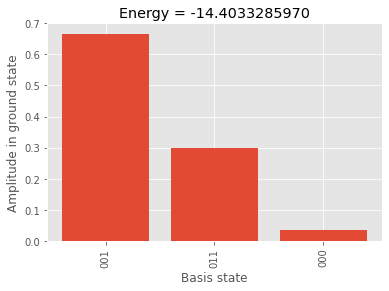

In [9]:
plot_ground_state_amplitudes(operator=ham_cs, num_qubits=num_sim_q)#, reverse_bitstrings=True)

## Running CS-VQE

Finally, we may perform a VQE routine taking as input the reduced Hamiltonian and Ansatz defined above.

In [19]:
import qreduce.circuit_tools as circ
import qreduce.circuit_execution_tools as circ_ex
from qiskit.circuit import QuantumCircuit

In [46]:
qc = QuantumCircuit(num_sim_q)
for index, bit in enumerate(ngs):
    q_pos = num_sim_q-1-index
    if int(bit)==1:
        qc.x(q_pos)

qc = circ.circ_from_paulis(circ=qc, paulis=list(anz_cs.keys()), trot_order=2)
circ.cancel_pairs(circ=qc, hit_set={'s', 'sdg'})
circ.cancel_pairs(circ=qc, hit_set={'h', 'h'})
bounds = np.array([(a-np.pi/2, a+np.pi/2) for a in anz_cs.values()]) # optimization bounds
qc.parameter_bounds = bounds

qc.draw(output='mpl')

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [44]:
vqe_result = circ_ex.vqe_simulation(ansatz=qc, operator=ham_cs, init_params=np.array(list(anz_cs.values())))

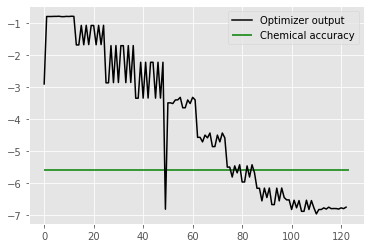

In [45]:
log_errors = np.log10(np.square(np.array(vqe_result['values'])-exact))
plt.plot(log_errors, color='black', label='Optimizer output')
plt.hlines(np.log10(0.0016**2), 0, vqe_result['counts'][-1], label='Chemical accuracy', color='green')
plt.legend()